In [46]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns   
import calendar
print (yf.__version__)

0.2.61


# Tubize (TUB.BR) Stock Analysis

## Overview
This notebook analyzes the stock performance of Financiere de Tubize (TUB.BR) - the mono holding company whose sole investment is a stake in UCB which is a biopharma company in Belgium - and compares it with UCB Pharma (UCB.BR) from 2005 to present.

## Key Sections

### 1. Data Download & Preparation
- Downloads historical price data for TUB.BR and UCB.BR from Yahoo Finance
- Cleans and structures data with Date and Ticker columns
- Calculates daily returns and cumulative returns

### 2. TUB.BR Performance Analysis
- **Last 5 Years Price Chart**: Displays closing price trends with FDA approval marker for Bimzelx (Oct 17, 2023)
- **Cumulative Returns**: Shows total return on investment from inception

### 3. Monthly Returns Comparison
- Calculates monthly returns for both tickers
- Visualizes side-by-side monthly return trends (2005-present)

### 4. Rolling Correlation Analysis
- Computes 12-month rolling correlation between TUB.BR and UCB.BR
- Identifies periods of high/low correlation between the two stocks

## Key Event
**FDA Approval of Bimzelx (Oct 17, 2023)**: Marked on the 5-year price chart to show market impact

## Data Source
Yahoo Finance (yfinance library)

In [25]:
tickers=['TUB.BR','UCB.BR']
data = yf.download(tickers, group_by='Ticker', start='2005-01-01')
data = data.stack(level=0).rename_axis(['Date','Ticker']).reset_index(level=1)
data.head()

[*********************100%***********************]  2 of 2 completed


Price,Ticker,Close,High,Low,Open,Volume
Date,,,,,,
2005-01-03,TUB.BR,24.266073,25.281150,24.266073,25.281150,0
2005-01-03,UCB.BR,24.620327,24.639606,24.048357,24.048357,148977
2005-01-04,TUB.BR,24.706575,25.147081,24.706575,25.147081,400
2005-01-04,UCB.BR,24.369686,24.620326,24.106195,24.620326,219092
2005-01-05,TUB.BR,25.089621,25.089621,25.089621,25.089621,200


In [26]:
data.describe()

Price,Close,High,Low,Open,Volume
count,10724.000000,10724.000000,10724.000000,10724.000000,1.072400e+04
mean,56.068021,56.667326,55.431315,56.053183,1.749468e+05
std,38.274595,38.740787,37.774714,38.211649,2.348956e+05
min,8.934751,9.532555,8.902437,9.467927,0.000000e+00
25%,26.900369,27.077001,26.563060,26.853456,7.116750e+03
50%,52.916103,53.509836,52.414298,52.978213,6.819400e+04
75%,70.454948,71.112660,69.868487,70.511193,2.838930e+05
max,260.200012,263.200012,256.200012,259.899994,4.420615e+06


In [27]:
tub_data = data[data['Ticker'] == 'TUB.BR'].drop(columns=['Ticker','High','Low','Open'])
tub_data['DailyChange']=tub_data['Close'].pct_change(periods=1)
tub_data['CumRet'] = (1 + tub_data['DailyChange']).cumprod()*100
tub_data.tail()





Price,Close,Volume,DailyChange,CumRet
Date,,,,
2025-12-01,212.0,58217,0.009524,873.647739
2025-12-02,211.0,30400,-0.004717,869.526759
2025-12-03,212.0,26870,0.004739,873.647739
2025-12-04,213.0,25287,0.004717,877.768719
2025-12-05,222.0,74577,0.042254,914.857538


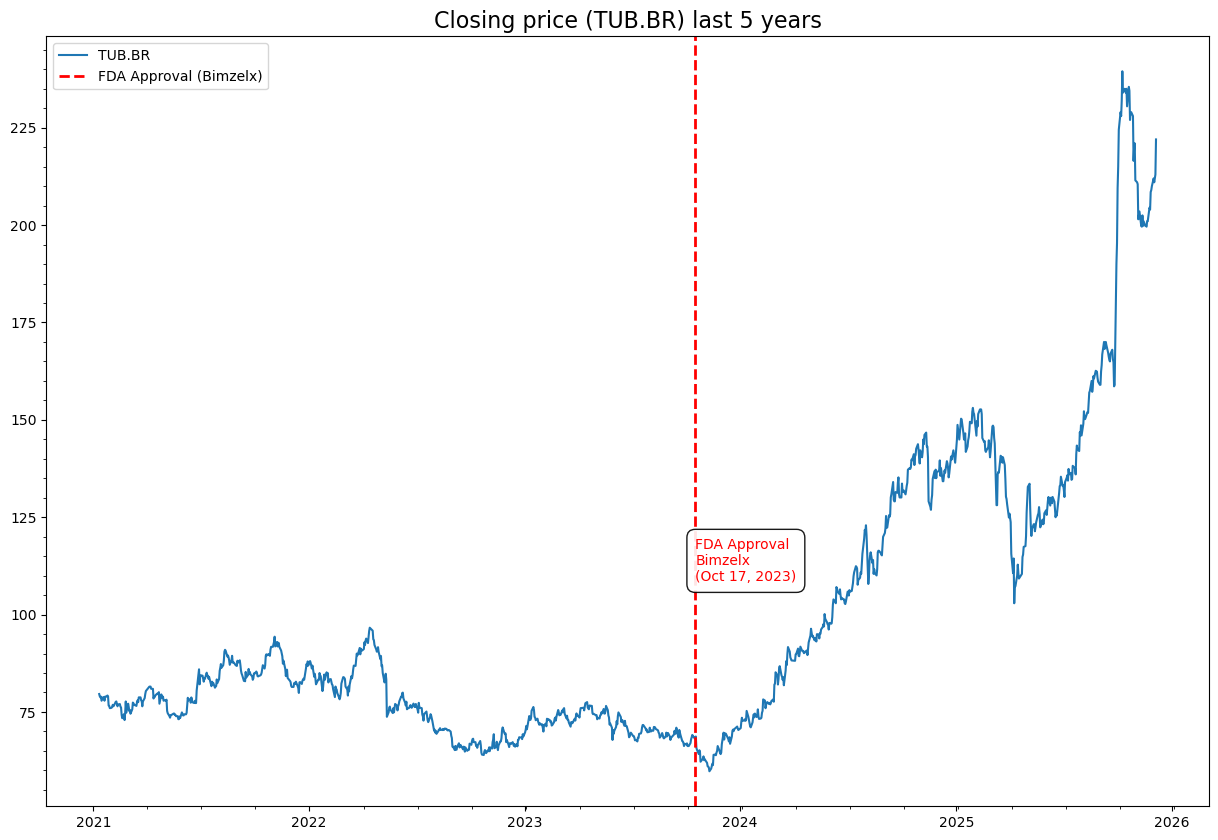

In [45]:
tub_data_5y = tub_data.tail(5*252)  # approximately 5 years of trading days (252 trading days/year)
plt.figure(figsize=(15,10))
plt.title('Closing price (TUB.BR) last 5 years', fontsize=16)
plt.minorticks_on()
plt.plot(tub_data_5y['Close'], label='TUB.BR')

# Add FDA approval date marker
fda_approval_date = pd.Timestamp('2023-10-17')
plt.axvline(x=fda_approval_date, color='red', linestyle='--', linewidth=2, label='FDA Approval (Bimzelx)')
plt.text(fda_approval_date, tub_data_5y['Close'].max() * 0.5, 'FDA Approval\nBimzelx\n(Oct 17, 2023)', 
         rotation=0, verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9), color='red', fontsize=10)

plt.legend()
plt.show()

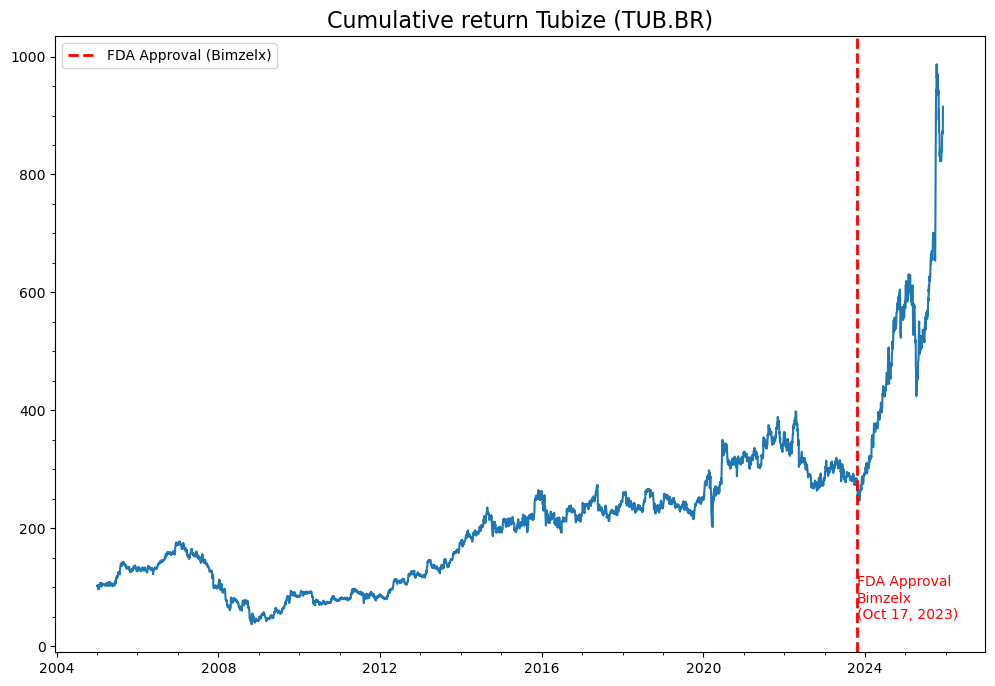

In [35]:
plt.figure(figsize=(12,8))
plt.title('Cumulative return Tubize (TUB.BR)', fontsize=16)
plt.minorticks_on()
plt.plot(tub_data['CumRet'])

# Add FDA approval date marker
fda_approval_date = pd.Timestamp('2023-10-17')
plt.axvline(x=fda_approval_date, color='red', linestyle='--', linewidth=2, label='FDA Approval (Bimzelx)')
plt.text(fda_approval_date, tub_data_5y['Close'].max() * 0.5, 'FDA Approval\nBimzelx\n(Oct 17, 2023)', 
         rotation=0, verticalalignment='top', color='red', fontsize=10)

plt.legend()
plt.show()

In [30]:
monthly_returns=data.groupby('Ticker').resample('M')['Close'].ffill().pct_change().reset_index()
monthly_returns = monthly_returns.dropna()
monthly_returns.head()

,Ticker,Date,Close
1,TUB.BR,2005-02-28,-0.022222
2,TUB.BR,2005-03-31,-0.009848
3,TUB.BR,2005-04-30,-0.013007
4,TUB.BR,2005-05-31,0.037209
5,TUB.BR,2005-06-30,0.117602


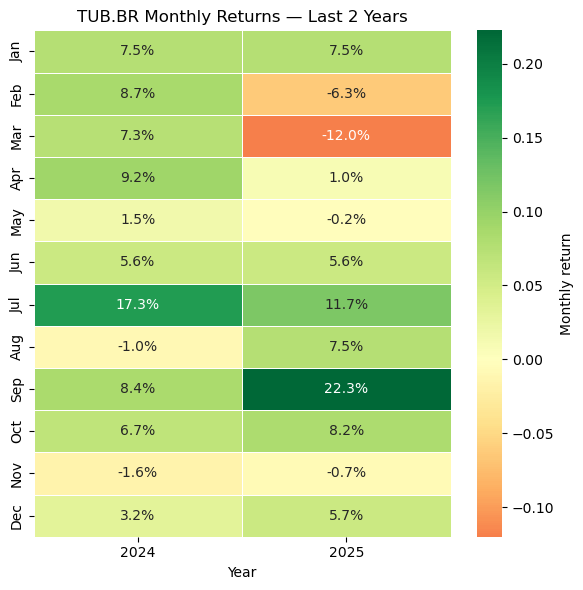

In [47]:
# prepare monthly returns for TUB.BR
monthly_returns['Date'] = pd.to_datetime(monthly_returns['Date'])
tub_monthly = monthly_returns[monthly_returns['Ticker'] == 'TUB.BR'].copy()

# filter last 2 years
last_date = tub_monthly['Date'].max()
start_date = last_date - pd.DateOffset(years=2) + pd.DateOffset(days=1)
tub_monthly = tub_monthly[tub_monthly['Date'] >= start_date]

# year/month columns for pivot
tub_monthly['Year'] = tub_monthly['Date'].dt.year
tub_monthly['Month'] = tub_monthly['Date'].dt.month

# pivot: rows = months (Jan..Dec), cols = years, values = monthly return (fraction)
pivot_heat = tub_monthly.pivot(index='Month', columns='Year', values='Close')

# ensure full month order and use abbreviated month names
months = list(range(1, 13))
pivot_heat = pivot_heat.reindex(months)
pivot_heat.index = [calendar.month_abbr[m] for m in pivot_heat.index]

# annotation strings (show percent or empty)
annot = pivot_heat.applymap(lambda x: f"{x:.1%}" if pd.notna(x) else "")

# plot heatmap
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(pivot_heat, ax=ax, cmap='RdYlGn', center=0, annot=annot, fmt='', linewidths=.5,
            cbar_kws={'label': 'Monthly return'})
ax.set_title('TUB.BR Monthly Returns — Last 2 Years')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

In [31]:
pivot = monthly_returns.pivot(index='Date', columns='Ticker', values='Close')
pivot.describe()

Ticker,TUB.BR,UCB.BR
count,251.000000,252.000000
mean,0.011492,0.008619
std,0.075842,0.094975
min,-0.328283,-0.891327
25%,-0.030705,-0.032901
50%,0.005326,0.003730
75%,0.054848,0.056149
max,0.266248,0.305152


datetime64[ns] 2005-01-31 00:00:00 2025-12-31 00:00:00


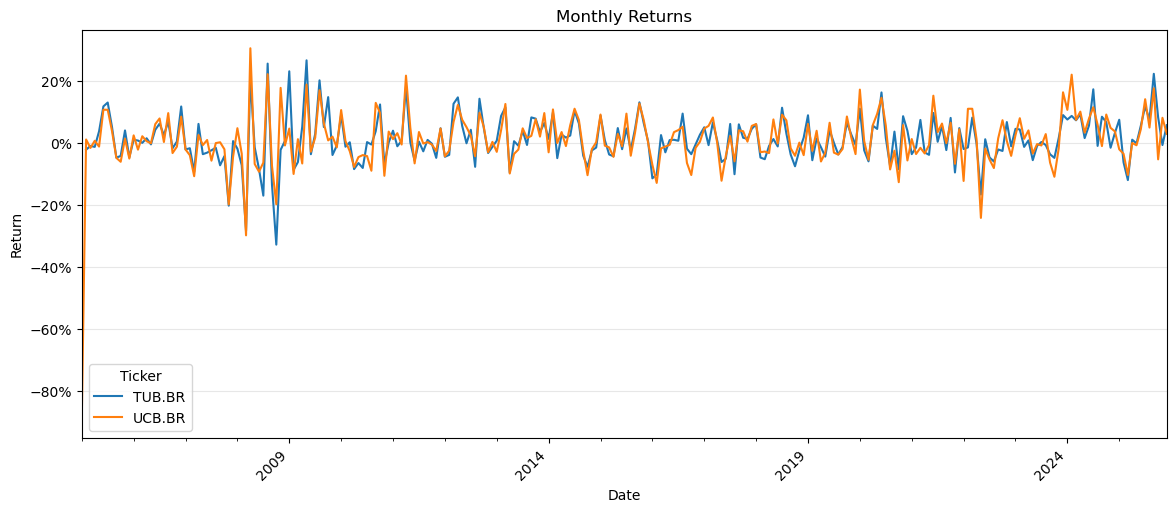

In [32]:

# Plot two lines (TUB.BR and UCB.BR). Adjust tickers list if different.
tickers_to_plot = ['TUB.BR', 'UCB.BR']
available = [t for t in tickers_to_plot if t in pivot.columns]

# ensure pivot index is a DatetimeIndex and sorted
pivot.index = pd.to_datetime(pivot.index)
if getattr(pivot.index, 'tz', None) is not None:
    pivot.index = pivot.index.tz_convert('UTC').tz_localize(None)
pivot.index = pd.DatetimeIndex(pivot.index)   # guarantee DatetimeIndex
pivot = pivot.sort_index()

fig, ax = plt.subplots(figsize=(14,6))
pivot[available].plot(ax=ax)

# Format y-axis as percent and x-axis by year
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

print(pivot.index.dtype, pivot.index.min(), pivot.index.max())
# ensure x-limits cover the data and rotate labels so they are visible
ax.set_xlim([pivot.index.min(), pivot.index.max()])
fig.autofmt_xdate()               # rotate & align date labels
ax.tick_params(axis='x', labelrotation=45)

ax.set_title('Monthly Returns')
ax.set_ylabel('Return')
ax.legend(title='Ticker')
ax.grid(axis='y', alpha=0.3)
plt.show()

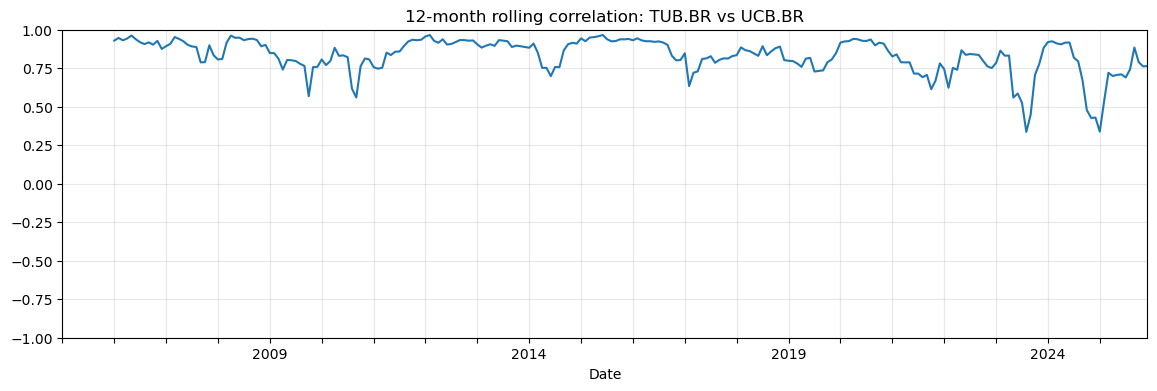

In [33]:
window = 12  # months
t1, t2 = 'TUB.BR', 'UCB.BR'

# ensure datetime index and tickers exist
pivot.index = pd.to_datetime(pivot.index)
rolling_corr = pivot[t1].rolling(window=window).corr(pivot[t2])

# plot rolling correlation
fig, ax = plt.subplots(figsize=(14,4))
rolling_corr.plot(ax=ax, color='tab:blue')
ax.set_ylim(-1, 1)
ax.set_title(f'{window}-month rolling correlation: {t1} vs {t2}')
#ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Explicit yearly ticks (one tick per calendar year)
years = pd.date_range(start=pivot.index.min().to_period('Y').start_time,
                      end=pivot.index.max().to_period('Y').start_time,
                      freq='YS')
ax.set_xticks(years)

ax.grid(alpha=0.3)
plt.show()